## Replication guide for "Higher-order Learning" using Python

-----

This notebook contains a detailed descriptions as well as the Python code for replicating all the simulations and analysis in Evdokimov and Garfagnini (2021). The headings are organized by figures and tables in the order they appear in the paper.  

-----

## Figure 1

### Player 1

Let $P_1(Orange|n, t)$ denote the probability assigned to the orange state by a Bayesian player, conditional on the number of orange balls $n$ observed in period $t$. This value is computed in the code below using the function `bayes(num_balls,period)`.

We assume in the simulations below that orange is the correct state, so that $P_1(Orange|n, t)$ represents the **normalized first-order belief**. 

The expected value of $P_1(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_1(Orange|n, t) \cdot f(n; Orange, t),
$$
where $f(n; Orange, t)={t \choose n} (2/3)^n \cdot (1/3)^{t-n}$ is the probablity of observing $n$ of orange balls in period $t$, obtained from the Binomial distribution for the orange state. 

### Player k for k>1 (private treatment)

In the private treatment, Player $k$'s expectation of the probability assigned by Player $k-1$ to the state being orange, conditional on the number of orange balls $n$ observed in period $t$, is given by:

\begin{align*}
P_{k}(Orange|n,t)&=P_1(Orange|n,t)\cdot \sum_{n'=1}^t P_{k-1}(Orange|n', t)\cdot f(n'; Orange, t) + \\
&+[1-P_1(Orange|n,t)]\cdot \sum P_{k-1}(Orange|n', t)\cdot f(n'; Purple, t)
\end{align*}

I.e., Player $k$ first forms a posterior belief about the state. For each possible state, she computes the expectation of Player $k-1$'s beliefs over all possible numbers $n'$ of orange balls the Player $k-1$ might observe, using the binomial distribution for that state. This value is computed in the code below using the function `bayes2(num_balls,period)` for Player 2 and `bayes3(num_balls,period)` for Player 3.

The expected value of $P_k(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_k(Orange|n, t) \cdot f(n; Orange, t),
$$
similar to its counterpart for Player 1 in the description above.

-----

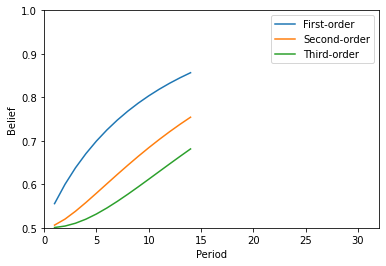

In [1]:
# import packages
from scipy.stats import binom
import matplotlib.pyplot as plt


# set the number of periods 

# change the right end point of the range to generate more predictions 
# (i.e., to 6 for 5 periods, 11 for 10 periods, and so on)
periods = list(range(1,15))


# define bayes' rule
def bayes(num_balls, period):
    return (((2/3) ** num_balls) * ((1/3) ** (period-num_balls))) \
    /(((2 / 3) ** num_balls) * ((1 / 3) ** (period - num_balls))+((1 / 3) ** num_balls) \
      * ((2 / 3) ** (period - num_balls)))


# initialize public beliefs list
beliefs_public = list()


# loop through periods and for each period compute expected first-order belief
for period in periods:
    expected_belief = 0
    for num_balls in range(period+1):
        expected_belief += bayes(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_public.append(expected_belief)


# define function for private second-order beliefs computed using bayes' rule
def bayes2(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1 - bayes(num_balls, period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private2 = list()


# loop through periods and for each period compute expected private second-
# order belief
for period in periods:
    expected_belief2 = 0
    for num_balls in range(period+1):
        expected_belief2 += bayes2(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private2.append(expected_belief2)


# define function for private third-order beliefs computed using Bayes' rule
def bayes3(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes2(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes2(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1- bayes(num_balls,period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private3 = list()


# loop through periods and for each period compute expected private third-
# order belief
for period in periods:
    expected_belief3 = 0
    for num_balls in range(period+1):
        expected_belief3 += bayes3(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private3.append(expected_belief3)


# MAKE THE PLOT!


plt.plot(periods, beliefs_public)
plt.plot(periods, beliefs_private2)
plt.plot(periods, beliefs_private3)
plt.axis([0, 32, 0.5, 1])
plt.xlabel('Period')
plt.ylabel('Belief')
plt.legend(['First-order', 'Second-order', 'Third-order'],
           loc='best')
plt.show()

## Figure 2 

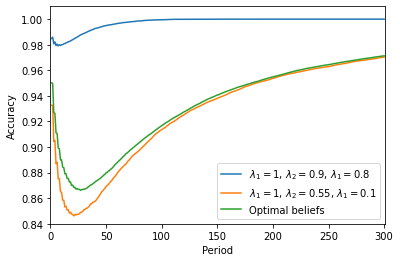

In [2]:
import random
from numpy import mean
import matplotlib.pyplot as plt


# define bayes' rule as function of the signal and the prior
def bayes(orange, prior):
    if orange == 1:
        return ( (2/3) * prior ) / ( (2/3) * prior + (1/3) * (1 - prior))
    if orange == 0:
        return ( (1/3) * prior ) / ( (1/3) * prior + (2/3) * (1 - prior))


# define a function that computes the simulated accuracy path for a given distribution of parameters
def accuracy(par1, par2, par3, num_teams, num_periods):
    acc_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior1 = 1/2
        prior2 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0,1])

        # draw a lambda for player 1 and a lambda from player 2 randomly
        lambda1 = random.choice([par1, par2, par3])
        lambda2 = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief1 = lambda1 * bayes(orange, prior1) + (1-lambda1) * prior1
            belief2 = lambda2 * bayes(orange, prior2) + (1-lambda2) * prior2
            # append belief accuracy for the given period to the list
            acc_lst.append(1 - abs(belief1-belief2))
            # update period and priors
            period = period + 1
            prior1 = belief1
            prior2 = belief2

        acc_dct[team]=acc_lst

    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# the code for generating the path of belief accuracies for a player
# who optimally takes into account the distribution of types
def optimal_accuracy(par1, par2, par3, num_teams, num_periods):
    acc_opt_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior = 1/2
        prior1 = 1/2
        prior2 = 1/2
        prior3 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0, 1])

        # draw a lambda for the non-optimal player randomly
        lamb = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_opt_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief = lamb * bayes(orange, prior) + (1 - lamb) * prior
            belief1 = par1 * bayes(orange, prior1) + (1 - par1) * prior1
            belief2 = par2 * bayes(orange, prior2) + (1 - par2) * prior2
            belief3 = par3 * bayes(orange, prior3) + (1 - par3) * prior3
            belief_opt = (belief1 + belief2 + belief3)/3
            # append belief accuracy for the given period to the list
            acc_opt_lst.append(1 - abs(belief - belief_opt))
            # update period and priors
            period = period + 1
            prior = belief
            prior1 = belief1
            prior2 = belief2
            prior3 = belief3

        acc_opt_dct[team] = acc_opt_lst
    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_opt_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# DRAW THE PATHS!

periods = list(range(1,301))
accuracies1 = accuracy(1, .9, .8, 5000, 300)
accuracies2 = accuracy(1, .55, .1, 5000, 300)
accuracies3 = optimal_accuracy(1, .55, .1, 5000, 300)

# print(accuracies1)
# print(accuracies2)
# print(accuracies3)

plt.plot(periods, accuracies1)
plt.plot(periods, accuracies2)
plt.plot(periods, accuracies3)
plt.axis([0, 301, 0.84, 1.01])
params = {'mathtext.default': 'regular' }
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.legend(['$\lambda_1=1$, $\lambda_2=0.9$, $\lambda_1=0.8$', '$\lambda_1=1$, $\lambda_2=0.55$, $\lambda_1=0.1$', 'Optimal beliefs'],
           loc='best')
plt.show()
